# Prepairing

## inSTAR PLATINum

In [ ]:
#metrics
!pip install -q git+https://github.com/google-research/bleurt.git
!pip install -q bert_score
!pip install -q rouge-score

#hugging
!pip install -q transformers
!pip install -q datasets

#keras
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


## config

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras_nlp
import keras

import transformers

import numpy as np

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## random

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
keras.utils.set_random_seed(SEED)
transformers.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## models

In [ ]:
ROBERTA = "deepset/roberta-base-squad2"
ELECTRA = "deepset/electra-base-squad2"
BART = "Primer/bart-squad2"

# Datasets

In [ ]:
import datasets

## datasets

In [ ]:
SQUAD_V2 = "squad_v2"
SQL_CONTEXT = "b-mc2/sql-create-context"
ADVERSARIAL_QA = "adversarial_qa"

In [ ]:
squad2 = datasets.load_dataset(SQUAD_V2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
sql = datasets.load_dataset(SQL_CONTEXT)

In [ ]:
adversarial_qa = datasets.load_dataset(ADVERSARIAL_QA, 'adversarialQA')

In [ ]:
squad2['train'].to_pandas().loc[0:0]

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."


In [ ]:
sql['train'].to_pandas().loc[0:0]

,answer,question,context
0,SELECT COUNT(*) FROM head WHERE age > 56,How many heads of the departments are older th...,CREATE TABLE head (age INTEGER)


In [ ]:
adversarial_qa['train'].to_pandas().loc[0:0]

,id,title,context,question,answers,metadata
0,7ba1e8f4261d3170fcf42e84a81dd749116fae95,Brain,Another approach to brain function is to exami...,What sare the benifts of the blood brain barrir?,"{'text': ['isolated from the bloodstream'], 'a...","{'split': 'train', 'model_in_the_loop': 'Combi..."


## tokenizers

In [ ]:
roberta_tokenizer = transformers.AutoTokenizer.from_pretrained(
  ROBERTA,
  cache_dir=f"./RoBERTa/{ROBERTA}",
  model_max_length=1024,
)
electra_tokenizer = transformers.AutoTokenizer.from_pretrained(
  ELECTRA,
  cache_dir=f"./ELECTRA/{ELECTRA}",
  model_max_length=1024,
)
bart_tokenizer = transformers.AutoTokenizer.from_pretrained(
  BART,
  cache_dir=f"./BART/{BART}",
  model_max_length=1024,
)

def lambda_roberta(question, context):
  tokenized = roberta_tokenizer.tokenize(question, context, add_special_tokens=False, truncation=True)
  return tokenized

def lambda_electra(question, context):
  tokenized = electra_tokenizer.tokenize(question, context, add_special_tokens=False, truncation=True)
  return tokenized

def lambda_bart(question, context):
  tokenized = bart_tokenizer.tokenize(question, context, add_special_tokens=False, truncation=True)
  return tokenized


lambda_tokenizers = {
    ROBERTA: lambda_roberta,
    ELECTRA: lambda_electra,
    BART: lambda_bart,
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## preprocess of data

In [ ]:
MAX_TOKENS = 128

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
def get_entire_dataset(dataset, names_arr):
  df_list = [dataset[name].to_pandas() for name in names_arr]
  return pd.concat(df_list)

In [ ]:
squad2 = get_entire_dataset(squad2, ['train','validation'])
sql = get_entire_dataset(sql, ['train'])
adversarial_qa = get_entire_dataset(adversarial_qa, ['train','validation','test'])

In [ ]:
def extract_answer(answer_dict):
    text_list = answer_dict.get('text', [])
    non_empty_text_list = [text for text in text_list if text]
    return non_empty_text_list[0] if non_empty_text_list else None

In [ ]:
ANSWER = 'answer'
CONTEXT = 'context'
QUESTION = 'question'

SPLITS = ['train', 'validation', 'test']

for dataset in [squad2, adversarial_qa]:
  dataset[ANSWER] = dataset['answers'].apply(extract_answer)
  dataset.dropna(subset=[ANSWER], inplace=True)

In [ ]:
def constraints_qa(dataset, tokenizers):
  conditions = []
  for _, example in dataset.iterrows():
    context = example[CONTEXT]
    question = example[QUESTION]
    answer = example[ANSWER]

    condition = True

    for tokenizer in iter(tokenizers):
      text = context + " " + answer
      tokenized = tokenizer(question, text)
      total_len = len(tokenized)

      if total_len > MAX_TOKENS-10:
        condition = False
        break

    conditions.append(condition)

  dataset = dataset[conditions]
  print(f"Current length: {len(dataset)}")
  return dataset

In [ ]:
squad2 = constraints_qa(squad2, lambda_tokenizers.values())

Current length: 12915


In [ ]:
sql = constraints_qa(sql, lambda_tokenizers.values())

Current length: 77176


In [ ]:
adversarial_qa = constraints_qa(adversarial_qa, lambda_tokenizers.values())

Current length: 5795


In [ ]:
def split_to_valid_test(dataset, valid, test):
  train, validation_and_test = train_test_split(dataset, test_size=valid+test)
  valid, test = train_test_split(validation_and_test, test_size=test/(valid + test))
  new_dataset = {
      'train': datasets.Dataset.from_dict(train),
      'validation': datasets.Dataset.from_dict(valid),
      'test': datasets.Dataset.from_dict(test)
  }
  return new_dataset

In [ ]:
squad2 = split_to_valid_test(squad2, 0.1, 0.1)
sql = split_to_valid_test(sql, 0.1, 0.1)
adversarial_qa = split_to_valid_test(adversarial_qa, 0.1, 0.1)

In [ ]:
import math
def save_percent_dataset(dataset, percent):
  num_shards = math.ceil(100/percent)

  for split in SPLITS:
    dataset[split] = dataset[split].shuffle(seed=SEED)
    dataset[split] = dataset[split].shard(num_shards=num_shards, index=0)

  return dataset

In [ ]:
sql = save_percent_dataset(sql,10)

In [ ]:
squad2

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer'],
     num_rows: 10332
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer'],
     num_rows: 1291
 }),
 'test': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer'],
     num_rows: 1292
 })}

In [ ]:
sql

{'train': Dataset({
     features: ['answer', 'question', 'context'],
     num_rows: 6174
 }),
 'validation': Dataset({
     features: ['answer', 'question', 'context'],
     num_rows: 772
 }),
 'test': Dataset({
     features: ['answer', 'question', 'context'],
     num_rows: 772
 })}

In [ ]:
adversarial_qa

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'metadata', 'answer'],
     num_rows: 4636
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'metadata', 'answer'],
     num_rows: 579
 }),
 'test': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'metadata', 'answer'],
     num_rows: 580
 })}

## dict

In [ ]:
dataset_dict = {
    SQUAD_V2: squad2,
    SQL_CONTEXT: sql,
    ADVERSARIAL_QA: adversarial_qa,
}

# Models

In [ ]:
BATCH_SIZE_GENERATE = 16

In [ ]:
import torch

In [ ]:
first_row = squad2['test'][0]
context = first_row[CONTEXT]
question = first_row[QUESTION]
answer = first_row[ANSWER]

print(f"Context: {context}\n")
print(f"Question: {question}\n")
print(f"Answer: {answer}")

question = [question]
context = [context]

Context: Canadian football is also played at the high school, junior, collegiate, and semi-professional levels: the Canadian Junior Football League, formed May 8, 1974, and Quebec Junior Football League are leagues for players aged 18–22, many post-secondary institutions compete in Canadian Interuniversity Sport for the Vanier Cup, and senior leagues such as the Alberta Football League have grown in popularity in recent years. Great achievements in Canadian football are enshrined in the Canadian Football Hall of Fame.

Question: What trophy is awarded to the winner of Canadian inter-university football competition?

Answer: Vanier Cup


## RoBERTa

In [ ]:
roberta_model = transformers.AutoModelForQuestionAnswering.from_pretrained(
    ROBERTA,
    cache_dir=f"./RoBERTa/{ROBERTA}",
).to(DEVICE)

def roberta_dict(questions, contexts):
  responses = []
  for i in range(0, len(questions), BATCH_SIZE_GENERATE):
    batch_questions = questions[i:i+BATCH_SIZE_GENERATE]
    batch_contexts = contexts[i:i+BATCH_SIZE_GENERATE]

    tokens = roberta_tokenizer(batch_questions, batch_contexts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_TOKENS)
    input_ids = tokens.input_ids.to(DEVICE)
    attention_mask = tokens.attention_mask.to(DEVICE)

    outputs = roberta_model(input_ids, attention_mask)

    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    for idx in range(outputs.start_logits.shape[0]):
      answer_start = torch.argmax(answer_start_scores[idx])
      answer_end = torch.argmax(answer_end_scores[idx]) + 1

      answer = roberta_tokenizer.convert_tokens_to_string(roberta_tokenizer.convert_ids_to_tokens(input_ids[idx][answer_start:answer_end]))
      responses.append(answer)
  return responses

respond = roberta_dict(question, context)
print(f"RoBERTa: {respond}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RoBERTa: [' Vanier Cup']


## ELECTRA

In [ ]:
electra_model = transformers.AutoModelForQuestionAnswering.from_pretrained(
    ELECTRA,
    cache_dir=f"./ELECTRA/{ELECTRA}",
).to(DEVICE)


def electra_dict(questions, contexts):
  responses = []
  for i in range(0, len(questions), BATCH_SIZE_GENERATE):
    batch_questions = questions[i:i+BATCH_SIZE_GENERATE]
    batch_contexts = contexts[i:i+BATCH_SIZE_GENERATE]

    tokens = electra_tokenizer(batch_questions, batch_contexts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_TOKENS)
    input_ids = tokens.input_ids.to(DEVICE)
    attention_mask = tokens.attention_mask.to(DEVICE)

    outputs = electra_model(input_ids, attention_mask)

    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    for idx in range(outputs.start_logits.shape[0]):
      answer_start = torch.argmax(answer_start_scores[idx])
      answer_end = torch.argmax(answer_end_scores[idx]) + 1

      answer = electra_tokenizer.convert_tokens_to_string(electra_tokenizer.convert_ids_to_tokens(input_ids[idx][answer_start:answer_end]))
      responses.append(answer)
  return responses

print(f"ELECTRA: {electra_dict(question, context)}")

ELECTRA: ['vanier cup']


## BART

In [ ]:
bart_model = transformers.AutoModelForQuestionAnswering.from_pretrained(
  BART,
  cache_dir=f"./BART/{BART}",
).to(DEVICE)

def bart_dict(questions, contexts):
  responses = []
  for i in range(0, len(questions), BATCH_SIZE_GENERATE):
    batch_questions = questions[i:i+BATCH_SIZE_GENERATE]
    batch_contexts = contexts[i:i+BATCH_SIZE_GENERATE]

    tokens = bart_tokenizer(batch_questions, batch_contexts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_TOKENS)
    input_ids = tokens.input_ids.to(DEVICE)
    attention_mask = tokens.attention_mask.to(DEVICE)

    outputs = bart_model(input_ids, attention_mask)

    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    for idx in range(outputs.start_logits.shape[0]):
      answer_start = torch.argmax(answer_start_scores[idx])
      answer_end = torch.argmax(answer_end_scores[idx]) + 1

      answer = bart_tokenizer.convert_tokens_to_string(bart_tokenizer.convert_ids_to_tokens(input_ids[idx][answer_start:answer_end]))
      responses.append(answer)
  return responses

print(f"BART: {bart_dict(question, context)}")

BART: [' Vanier Cup,']


## dict

In [ ]:
models_dict = {
    'RoBERTa': roberta_dict,
    'ELECTRA': electra_dict,
    'BART': bart_dict,
}

# Metrics

In [ ]:
from typing import List

## EditDistance

In [ ]:
edit_distance = keras_nlp.metrics.EditDistance(normalize=False)

def edit_distance_dict(y_true, y_pred) -> List[float]:
  true = [ans.split() for ans in y_true]
  pred = [pre.split() for pre in y_pred]
  if DEVICE.type == 'cpu':
    return edit_distance(true, pred).numpy().tolist()

  return edit_distance(true, pred).cpu().numpy().tolist()

EditDistance is a string metric that quantify how dissimilar two strings are to one another. It measures this by counting the minimum number of operations required to transform one string into the other

## RougeN

In [ ]:
rouge_n = keras_nlp.metrics.RougeN(order=3)

def rouge_n_dict(y_true, y_pred) -> List[float]:
  if DEVICE.type == 'cpu':
    return rouge_n(y_true, y_pred)["f1_score"].numpy().tolist()

  return rouge_n(y_true, y_pred)["f1_score"].cpu().numpy().tolist()

RougeN is a set of metrics that measures the overlap of n-grams between the model output and reference sentence.

## Bleurt

In [ ]:
bleurt = datasets.load_metric('bleurt', "bleurt-tiny-512", trust_remote_code=True)

def bleurt_dict(y_true, y_pred) -> List[float]:
  return bleurt.compute(predictions=y_pred, references=y_true)['scores']

# yeah, thanks for that "evaluate" ad, but it doesn't work with keras 3.

<ipython-input-42-ce9e1b0d2d0a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleurt = datasets.load_metric('bleurt', "bleurt-tiny-512", trust_remote_code=True)


Bleurt is an evaluation metric that takes a pair of sentences as input, a reference and a candidate, and it returns a score that indicates to what extent the candidate is fluent and conveys the meaning of the reference.

## BertScore

In [ ]:
bert_score = datasets.load_metric('bertscore', trust_remote_code=True, model_type='bert-base-uncased')

def bert_score_dict(y_true, y_pred) -> List[float]:
  return bert_score.compute(predictions=y_pred, references=y_true, lang='en')['recall']

BertScore is a metric that calculates the similarity between a model respond output and a reference sentence using sentence representation (embeddings from BERT).

## dict

In [ ]:
metrics_dict = {
    "EditDistance": edit_distance_dict,
    "RougeN": rouge_n_dict,
    "Bleurt": bleurt_dict,
    "BertScore": bert_score_dict,
}

# Diagrams

In [ ]:
import matplotlib.pyplot as plt

## get model responds

In [ ]:
def get_model_responds(dataset, model):
  contexts = dataset['test'][CONTEXT]
  questions = dataset['test'][QUESTION]
  answers = dataset['test'][ANSWER]

  responds = model(questions, contexts)
  return responds, answers

## plot function

In [ ]:
def plot_dataset(dataset, dataset_name, dict_models, dict_metrics, colors):
    data = {}

    models_responds = []
    true_lables = []
    for model in dict_models.values():
      responds, answers = get_model_responds(dataset,model)
      models_responds.append(responds)
      true_lables.append(answers)


    for metric_name, metric in dict_metrics.items():
        models = list(dict_models.keys())
        values = []

        for responds, answers in zip(models_responds, true_lables):
          results = metric(answers, responds)
          mean_result = np.mean(results) if results else 0

          values.append(mean_result)

        data[metric_name] = {'models': models, 'values': values, 'colors': colors}

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    epsilon = 0.001

    for ax, (title, plot_data) in zip(axs.flatten(), data.items()):
        ax.bar(plot_data['models'], plot_data['values'], color=plot_data['colors'])
        ax.set_title(title)
        ax.set_xlabel('Models')
        ax.set_ylabel('Evaluation metrics')
        ax.autoscale(tight=True)

        min_val = min(plot_data['values'])
        max_val = max(plot_data['values'])
        border = abs(max_val-min_val)*0.1 + epsilon

        ax.set_ylim(min_val - border, max_val + border)

    fig.suptitle(dataset_name, fontsize=16)

    plt.tight_layout()
    plt.show()

## plot metrics

In [ ]:
COLORS = ['purple','green','olive']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


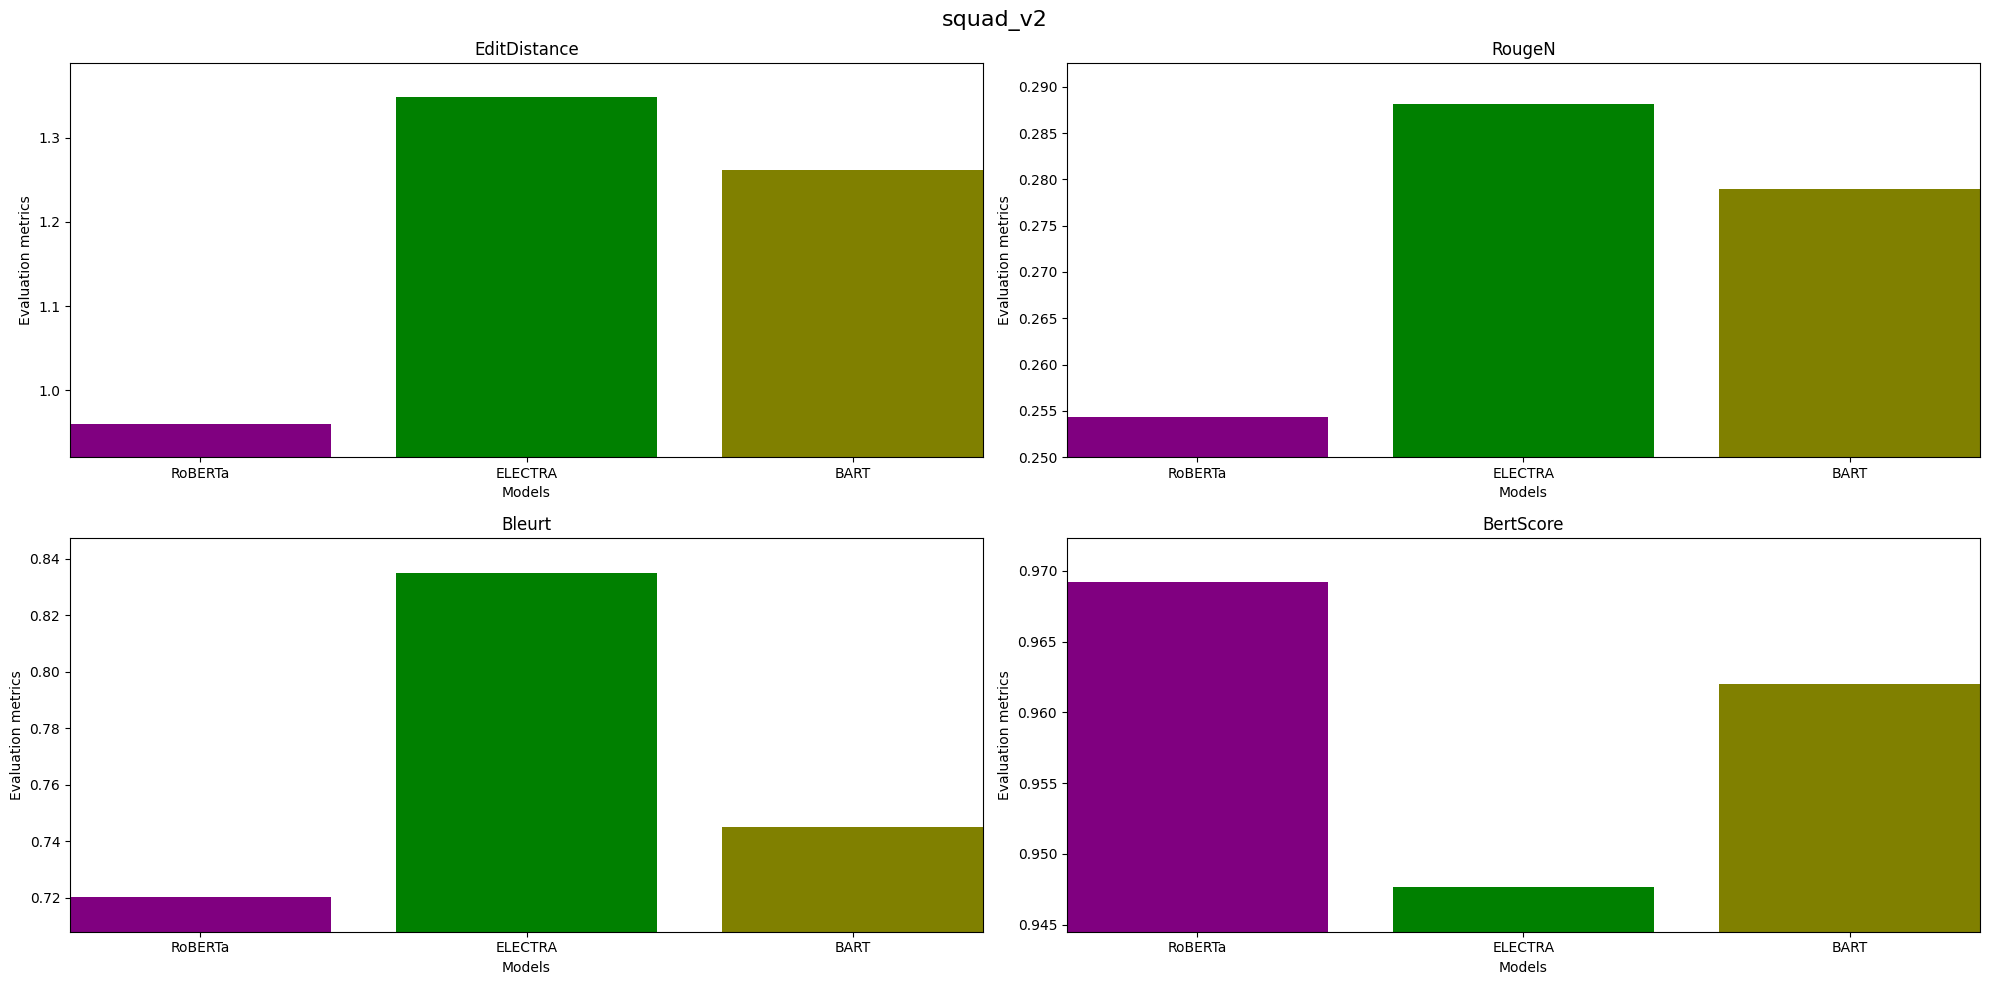

In [ ]:
plot_dataset(squad2, SQUAD_V2, models_dict, metrics_dict, COLORS)

The RoBERTa, BART and ELECTRA models were trained on the SQuAD2 dataset, and while it may seem a bit pointless to evaluate these models on the same dataset on which they were trained, it is worth noting that their performance metrics are remarkably similar. RoBERTa outperforms the others in terms of EditDistance and BertScore, while ELECTRA tops RougeN and Bleurt. BART consistently secures second place in all metrics. However, the similarity is so great that it can be argued that there is essentially no noticeable difference in their performance in the SQuAD2 dataset.

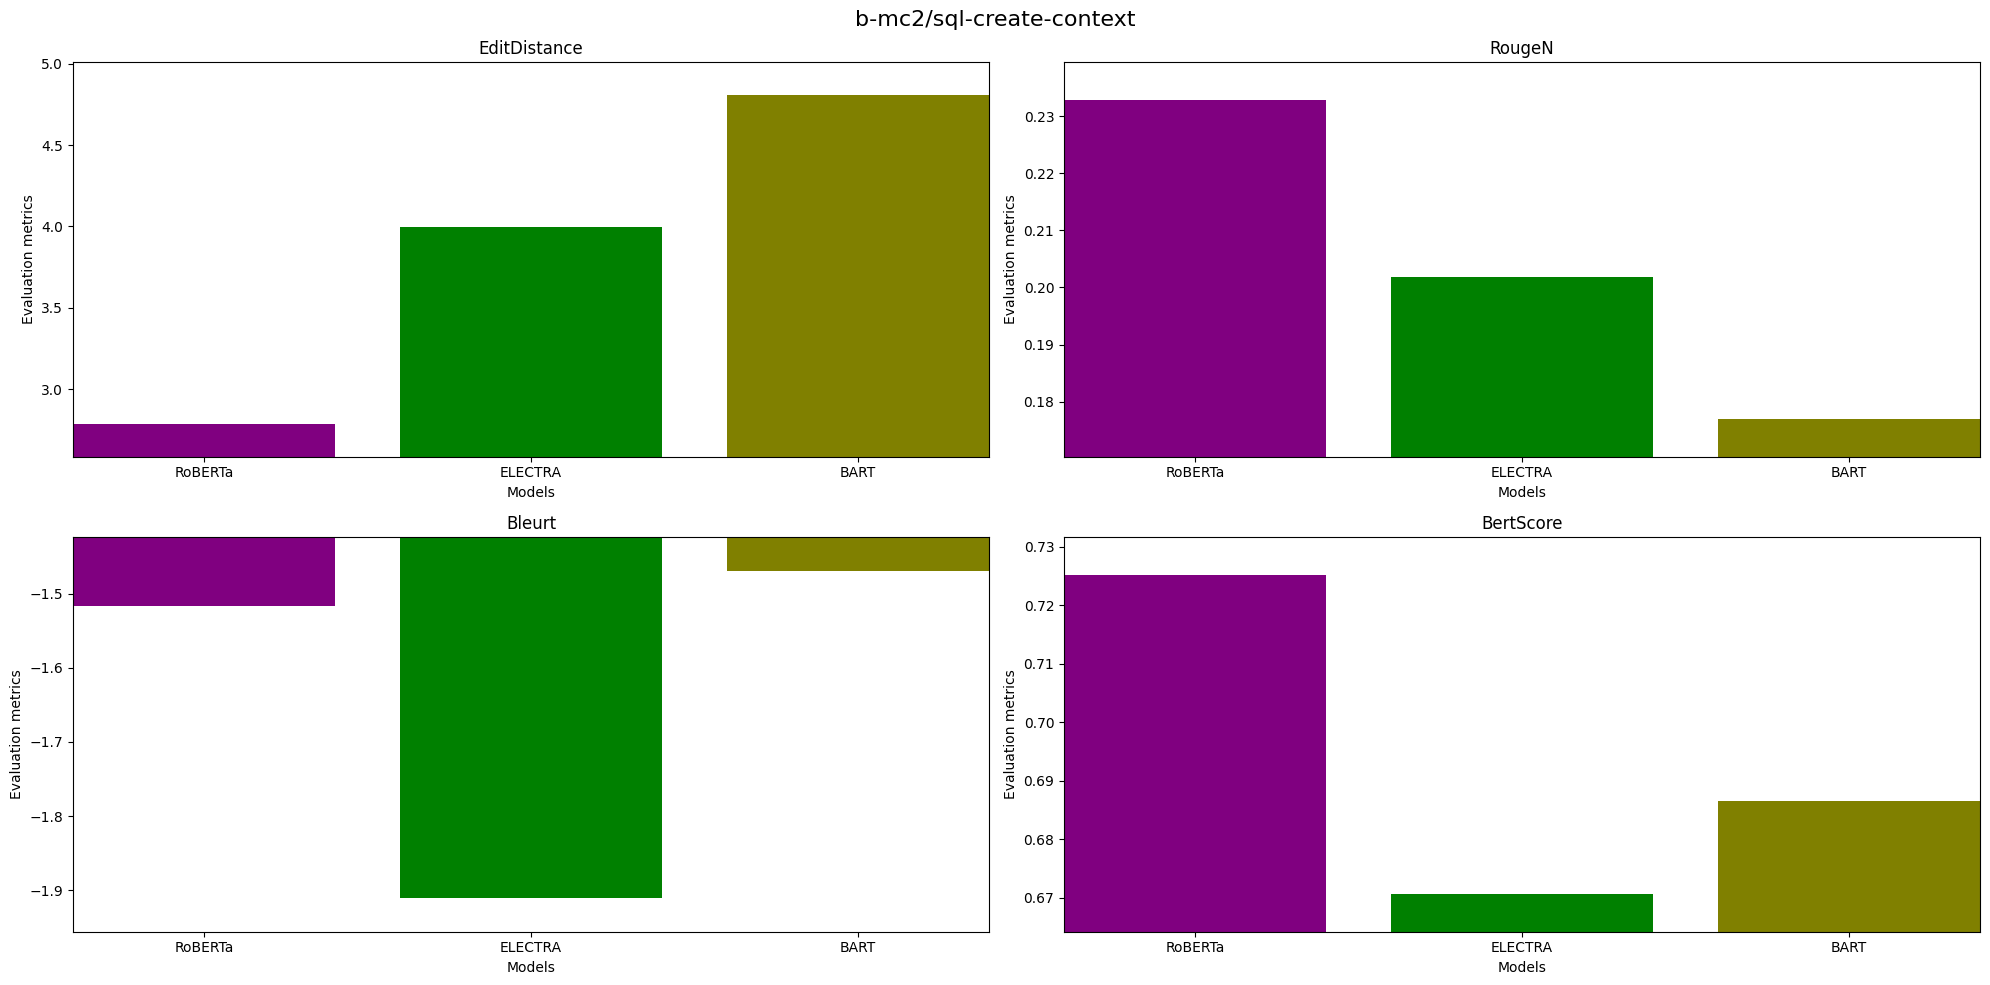

In [ ]:
plot_dataset(sql, SQL_CONTEXT, models_dict, metrics_dict, COLORS)

For the "b-mc2/sql-create-context" dataset, RoBERT outperforms all other models on various metrics, with the exception of Bleurt. For the Bleurt metric, RoBERT's performance is comparable to that of BART.

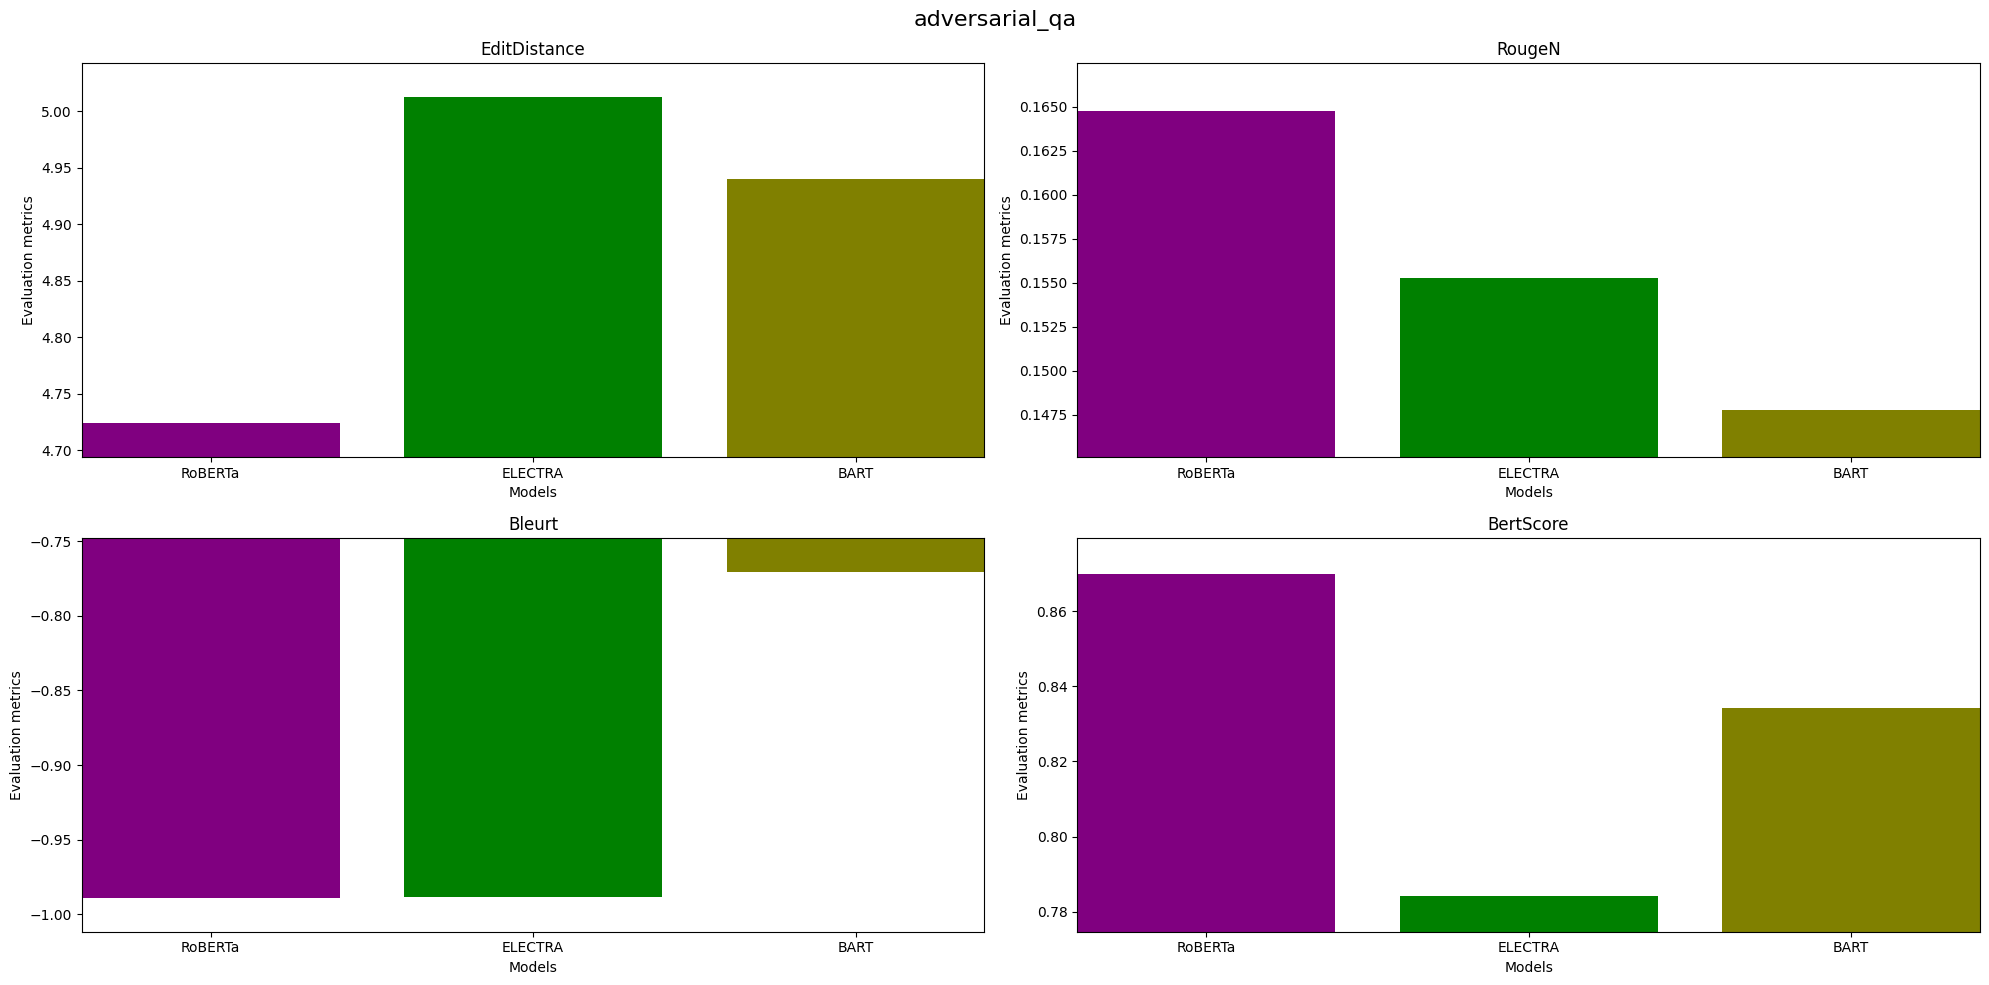

In [ ]:
plot_dataset(adversarial_qa, ADVERSARIAL_QA, models_dict, metrics_dict, COLORS)

In the context of the adversarial-qa dataset, RoBERTa outperforms all other models in various metrics, except Bleurt, where BART wins. However, this good performance of RoBERT does not necessarily mean that other models are inferior.

In summary, RoBERTa is shown to be the better model in this comparison because of its better ability to understand different contexts. In theory, this means that RoBERTa can handle a wider range of tasks more efficiently than other models. However, it should be noted that the differences in performance are minimal and all models show strong capabilities.